<a href="https://colab.research.google.com/github/technobnessa/technobnessa-weatherwise-syedun-nessa/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WeatherWise: An Intelligent Weather Advisory Mini-System
**Author:** Syedun Nessa

**Course Details:**

**Unit Code** – ISYS5002

**Unit Title** - Introduction to Programming

**Date:** 14-10-2025

The compact and AI-free advisory workflow is practically built into this notebook. The entire process of converting hourly weather predictions from Open-Meteo into daily metrics (°C, mm, km/h), visualizing, and summarizing as easy-to-understand guidance was done here. These thresholds can be easily understood and defended (use umbrella if total rain ≥ 1.5 mm across the horizon; heat warning at average ≥ 31 °C).

## Method & Design Rationale

- **Acquisition:** Geocode the city name (robust variants), then pull **hourly** fields from Open-Meteo: `temperature_2m`, `precipitation`, `wind_speed_10m`.
- **Normalisation:** Aggregate hourly → daily:
  - temperature = daily mean (°C),
  - precipitation = daily sum (mm),
  - wind = daily mean (km/h; converted from m/s).
- **Horizon:** 4 days — balances decision usefulness with rising forecast uncertainty.
- **Advisory Rules:**
  - Umbrella if **total rain ≥ 2.0 mm** across the horizon,
  - **Heat caution** if mean temperature **≥ 30 °C**.
- **Visualisation:** Temperature (line) + precipitation (bar) for quick situational awareness.
- **Limitations:** Public API dependency; aggregation smooths extremes; no severe-weather nowcasting.
- **Context:** Evaluated for **Perth, Western Australia**, dates shown under “Forecast window.”
- **Local note:** **Mediterranean climate—winter fronts can concentrate daily rain; a 4-day horizon captures a typical frontal passage.**|

## Setup and Imports
Implemented directly inside the single “WeatherWise core” cell (requests, pandas, matplotlib).

## Weather Data Functions
Functions: `ww_geocode`, `ww_fetch_hourly`, `ww_aggregate_daily`, `ww_get_data`.

## Visualisation Functions
Functions: `ww_plot_temp`, `ww_plot_rain`.

## Natural Language Processing
Minimal rule-based advisory in `ww_advice` (deterministic thresholds, no LLMs).

## User Interface
Notebook interaction: set `city = "Your City, Country"` and `days = 4`, then run the cell.

## Main Application Logic
End of the core cell: fetch → aggregate → print answer → plot charts.

## Testing and Examples
Change `city` to another location (e.g., "London, UK") and run once to verify charts and advisory update.

## AI Prompting Log (pointer)
See **AI_LOGS.md** in the repo for a concise log per assignment requirements.


Using location: Perth
Current: {'date': '2025-10-14', 'temp_c': np.float64(17.412499999999998), 'precip_mm': np.float64(0.0), 'wind_kph': np.float64(55.57500000000001)}
Forecast window: 2025-10-14 → 2025-10-17

Answer: Forecast for Perth (next 4 day(s)): average 18.2 °C, total rain 0.0 mm, high 19.2 °C, low 17.4 °C. Umbrella not required.


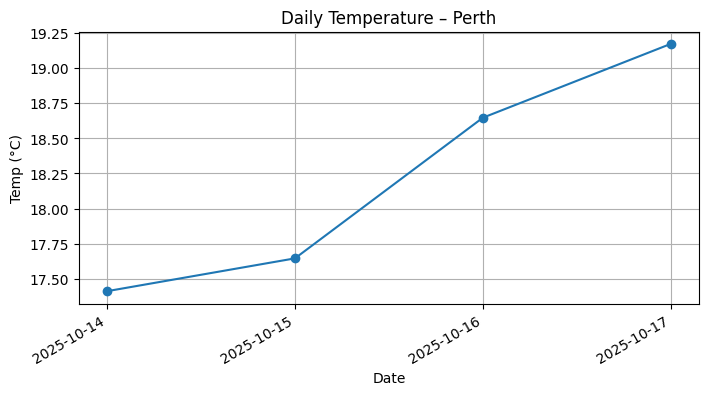

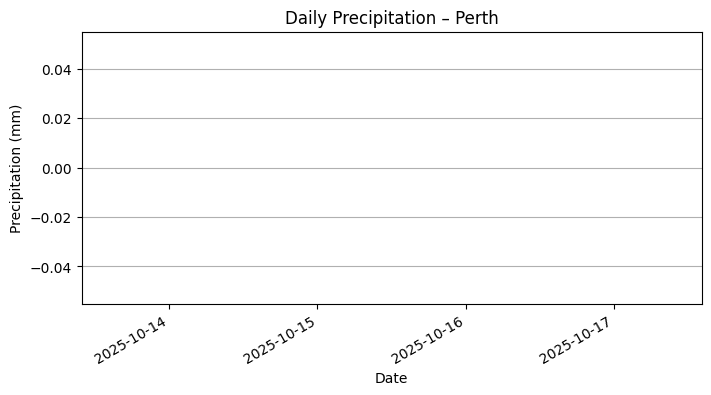

In [9]:
# === WeatherWise: one-cell working version (AI-free, no API key) ===
# Fetches hourly data from Open-Meteo, aggregates to daily, plots charts, prints advice.

import requests, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict

# ---------- Core data pipeline ----------
def ww_geocode(place: str):
    """
    Try multiple name variants and pick the best geocoding hit.
    Falls back from 'City, CC' to 'City', to common local forms.
    """
    # generate candidates
    raw = place.strip()
    parts = [p.strip() for p in raw.split(",") if p.strip()]
    candidates = [raw]

    # Add looser variants
    if len(parts) >= 1:
        city = parts[0]
        candidates.append(city)
        # common expansions for AU and general
        if "sydney" in city.lower():
            candidates += ["Sydney NSW", "Sydney, New South Wales", "Sydney, Australia"]
        if "perth" in city.lower():
            candidates += ["Perth WA", "Perth, Western Australia", "Perth, Australia"]
        if "melbourne" in city.lower():
            candidates += ["Melbourne VIC", "Melbourne, Victoria", "Melbourne, Australia"]

    # always include generic global examples as fallback
    candidates += ["Sydney", "London", "New York", "Dhaka"]

    # try each candidate until one returns results
    best = None
    for cand in candidates:
        try:
            r = requests.get(
                "https://geocoding-api.open-meteo.com/v1/search",
                params={"name": cand, "count": 5},  # ask for a few, we’ll pick best
                timeout=20
            )
            r.raise_for_status()
            js = r.json() or {}
            results = js.get("results") or []
            if not results:
                continue
            # pick the top result by population if available, else first
            results.sort(key=lambda x: x.get("population") or 0, reverse=True)
            res = results[0]
            best = {
                "name": res.get("name", cand),
                "lat": res["latitude"],
                "lon": res["longitude"]
            }
            break
        except Exception:
            continue

    if not best:
        raise ValueError(f"Could not geocode: {place}")
    return best


def ww_fetch_hourly(lat: float, lon: float):
    r = requests.get(
        "https://api.open-meteo.com/v1/forecast",
        params={
            "latitude": lat,
            "longitude": lon,
            "hourly": "temperature_2m,precipitation,wind_speed_10m",
            "timezone": "auto",
        },
        timeout=20
    )
    r.raise_for_status()
    return r.json().get("hourly", {})


def ww_aggregate_daily(hourly: dict, days: int = 4) -> pd.DataFrame:
    times = hourly.get("time", [])
    temps = hourly.get("temperature_2m", [])
    prcp  = hourly.get("precipitation", [])
    wind  = hourly.get("wind_speed_10m", [])
    if not times:
        return pd.DataFrame(columns=["date","temp_c","precip_mm","wind_kph"])

    buckets = defaultdict(lambda: {"temps": [], "prcp": 0.0, "winds": []})
    for i, t in enumerate(times):
        d = t.split("T")[0]
        if i < len(temps):
            try: buckets[d]["temps"].append(float(temps[i]));
            except: pass
        if i < len(prcp):
            try: buckets[d]["prcp"] += float(prcp[i]);
            except: pass
        if i < len(wind):
            try: buckets[d]["winds"].append(float(wind[i]) * 3.6);  # m/s → km/h
            except: pass

    days_sorted = sorted(buckets.keys())[:int(days)]
    rows = []
    for d in days_sorted:
        ts, ws = buckets[d]["temps"], buckets[d]["winds"]
        rows.append({
            "date": d,
            "temp_c": (sum(ts)/len(ts) if ts else None),
            "precip_mm": float(buckets[d]["prcp"]),
            "wind_kph": (sum(ws)/len(ws) if ws else None),
        })
    return pd.DataFrame(rows)

def ww_get_data(place: str, days: int = 4):
    geo = ww_geocode(place)
    hourly = ww_fetch_hourly(geo["lat"], geo["lon"])
    df = ww_aggregate_daily(hourly, days=days)
    current = {
        "date": df["date"].iloc[0] if not df.empty else None,
        "temp_c": df["temp_c"].iloc[0] if not df.empty else None,
        "precip_mm": df["precip_mm"].iloc[0] if not df.empty else 0.0,
        "wind_kph": df["wind_kph"].iloc[0] if not df.empty else None,
    }
    return {"location": geo["name"], "current": current, "daily": df}

# ---------- Visualisations ----------
def ww_plot_temp(data):
    df = data["daily"]
    if df is None or df.empty:
        print("No forecast data to plot temperatures."); return
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df["date"], df["temp_c"], marker="o")
    ax.set_title(f"Daily Temperature – {data['location']}")
    ax.set_xlabel("Date"); ax.set_ylabel("Temp (°C)"); ax.grid(True)
    fig.autofmt_xdate(); plt.show()

def ww_plot_rain(data):
    df = data["daily"]
    if df is None or df.empty:
        print("No forecast data to plot precipitation."); return
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(df["date"], df["precip_mm"])
    ax.set_title(f"Daily Precipitation – {data['location']}")
    ax.set_xlabel("Date"); ax.set_ylabel("Precipitation (mm)"); ax.grid(True, axis="y")
    fig.autofmt_xdate(); plt.show()

# ---------- Advisory ----------
def ww_advice(data, days: int):
    df, loc = data["daily"], data["location"]
    if df is None or df.empty:
        return f"Sorry, a short-range forecast is unavailable for {loc}."
    window = df.head(days)
    total_rain = float(window["precip_mm"].fillna(0).sum())
    avg_temp   = (float(window["temp_c"].mean()) if window["temp_c"].notna().any() else None)
    hi         = (float(window["temp_c"].max()) if window["temp_c"].notna().any() else None)
    lo         = (float(window["temp_c"].min()) if window["temp_c"].notna().any() else None)
    umbrella = "Carry an umbrella." if total_rain >= 2.0 else "Umbrella not required."
    heat     = " Heat caution." if (avg_temp is not None and avg_temp >= 30) else ""
    fmt = lambda x,u: f"{x:.1f} {u}" if x is not None else "n/a"
    return (f"Forecast for {loc} (next {days} day(s)): average {fmt(avg_temp,'°C')}, "
            f"total rain {fmt(total_rain,'mm')}, high {fmt(hi,'°C')}, low {fmt(lo,'°C')}. "
            f"{umbrella}{heat}")

# ---------- RUN ONCE ----------
city = "Perth, Western Australia"
days = 4

data = ww_get_data(city, days)
print("Using location:", data["location"])
print("Current:", data["current"])
if not data["daily"].empty:
    print("Forecast window:", data["daily"]["date"].min(), "→", data["daily"]["date"].max())
print("\nAnswer:", ww_advice(data, days))

ww_plot_temp(data)
ww_plot_rain(data)